## Importing Libs 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from models import *
from layers import *
from train import *
from test import *
from vision_dataloaders import *
from plots import *
from torchsummary import summary
from visualize import *
from diagnostics import *

## Load Data 

### Getting normalization values

In [3]:
tfm_names = ['tensor']

tfms = create_transform(tfm_names)

data = VisionData.load(tfms=tfms,train=True)

u,s=data.images.mean((0,1,2))/255,data.images.std((0,1,2))/255

Files already downloaded and verified


In [4]:
u,s

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

### Trying augmentations 

Need to apply augmentations as specified in the assignment:
Padding(4)-> random crop(32),FlipLR, cutout((8,8))

In [5]:
aug_data = VisionData.load(name='CIFAR10')

Files already downloaded and verified


In [6]:
img=[aug_data.images[20]]*32

In [7]:
aug_data.images=np.array(img)

In [8]:
assert np.allclose(aug_data[0][0],aug_data[1][0])

In [9]:
tfms = create_transform(tfm_names=['normalize','pad','crop','hflip','cutout','tensor'],padded_size=(40,40),norm_constants=(u,s),
                        cutout_size=8,cutout_fillvalue=u,cutout_prob=1.,crop_size=(32,32))
                       

In [10]:
aug_data.tfms=tfms

In [11]:
tfms

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784], max_pixel_value=255.0),
  PadIfNeeded(always_apply=False, p=1.0, min_height=40, min_width=40, border_mode=4, value=None, mask_value=None),
  RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(32, 32), height=32, width=32, w2h_ratio=1.0, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  Cutout(always_apply=False, p=1.0, num_holes=1, max_h_size=8, max_w_size=8),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [12]:
isCUDA = torch.cuda.is_available()
dev = torch.device('cuda') if isCUDA else torch.device('cpu')
dataloader_args = dict(shuffle=True,num_workers=4,batch_size = 8,pin_memory=True) if isCUDA else dict(shuffle=True,batch_size = 8//2)
dl=getDataLoader(aug_data,**dataloader_args)

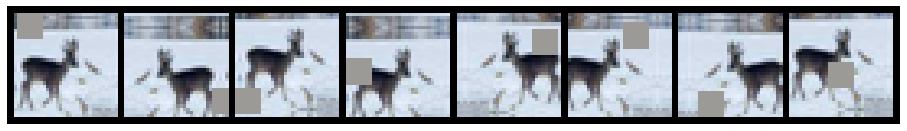

In [13]:
show_batch(dl,figsize=(16,16))

### Defining DataLoaders

In [14]:
train_tfms = create_transform(tfm_names=['normalize','pad','crop','hflip','cutout','tensor'],padded_size=(40,40),norm_constants=(u,s),
                        cutout_size=8,cutout_fillvalue=u,cutout_prob=1.,crop_size=(32,32))
                       
test_tfms = create_transform(tfm_names=['normalize','tensor'],norm_constant=(u,s))


train_data = VisionData.load(name='CIFAR10',tfms=train_tfms,train=True)
test_data = VisionData.load(name='CIFAR10',tfms=test_tfms,train=False)

train_dl,test_dl = getTrainTestLoader((train_data,test_data),BS=512)

Files already downloaded and verified
Files already downloaded and verified


## Model development 

In [15]:
model = ResNetCIFAR90().cuda()

In [16]:
model

ResNetCIFAR90(
  (prep_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cblock1_shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (cblock1_resblock): ResBlock(
    (shortcut): Sequential()
    (conv): Sequential(
      (0): ConvLayer(
        (lyrs): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ConvLayer(
        (lyrs): Sequential(
          (0): Conv2

In [17]:
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
        ConvLayer-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        ConvLayer-14          [-1, 128,

## LR Range test

In [18]:
BATCH_SIZE=512
n_batches_per_epoch = data.images.shape[0]//BATCH_SIZE+1
n_epochs = 20

In [19]:
model1 = ResNetCIFAR90().cuda()
opt1 = optim.SGD(model1.parameters(),lr=1e-3,momentum=0.95)
dls={}
dls['train']=train_dl
dls['valid']=test_dl
loss_func = nn.CrossEntropyLoss()
#sched = StepLR(opt,step_size=15,gamma=0.3)

In [20]:
finder = LRFinder(model1,opt1,loss_func)

In [21]:
finder.range_test(dls['train'],num_iter=n_batches_per_epoch*n_epochs,
                  metric='accuracy',step_mode='exp',
                  start_lr=1e-6,break_on_loss=False,end_lr=10)

100%|██████████| 1960/1960 [04:24<00:00,  7.42it/s]

Learning rate search is over. Please use self.plot to look at the graph


In [22]:
opt1.param_groups[-1]['momentum']

0.95

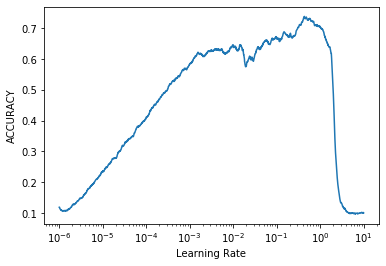

In [23]:
finder.plot(skip_start=0,to_plot='metric',lr_scale='log',skip_end=1)

## Training Model 

In [62]:
model = ResNetCIFAR90().cuda()
opt = optim.SGD(model.parameters(),lr=1e-2,momentum=0.9)
dls={}
dls['train']=train_dl
dls['valid']=test_dl
BATCH_SIZE = 512
N_EPOCHS=24
total_steps = 24*len(dls['train'])
loss_func = nn.CrossEntropyLoss()
sched = get_scheduler(opt,'onecycle',max_lr=0.03,pct_start=5/24,total_steps=total_steps
                      ,anneal_strategy='linear',div_factor=8,final_div_factor=8,
                      cycle_momentum=False,max_momentum=0.9,base_momentum=0.7)

In [63]:
ldict = train(model,opt,dls,loss_func,24,scheduler=sched,device='cuda',sched_batchwise=True)

Training Loss:1.655, Training Acc:36.607: 100%|██████████| 98/98 [00:13<00:00,  7.25it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[0/24]--> Training Loss:2.848, Training Accuracy:27.838, Validation Loss:2.567, Validation Accuracy:13.460
Learning rate: 0.009010736196319018


Training Loss:1.552, Training Acc:46.429: 100%|██████████| 98/98 [00:13<00:00,  7.21it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[1/24]--> Training Loss:1.619, Training Accuracy:46.000, Validation Loss:2.450, Validation Accuracy:23.820
Learning rate: 0.014271472392638035


Training Loss:1.403, Training Acc:52.976: 100%|██████████| 98/98 [00:13<00:00,  7.21it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[2/24]--> Training Loss:1.373, Training Accuracy:55.412, Validation Loss:2.616, Validation Accuracy:29.190
Learning rate: 0.019532208588957052


Training Loss:1.505, Training Acc:59.524: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[3/24]--> Training Loss:1.260, Training Accuracy:60.784, Validation Loss:1.927, Validation Accuracy:38.740
Learning rate: 0.02479294478527607


Training Loss:1.693, Training Acc:62.500: 100%|██████████| 98/98 [00:13<00:00,  7.21it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[4/24]--> Training Loss:1.247, Training Accuracy:64.360, Validation Loss:1.457, Validation Accuracy:49.300
Learning rate: 0.029984140037593983


Training Loss:1.007, Training Acc:69.345: 100%|██████████| 98/98 [00:13<00:00,  7.22it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[5/24]--> Training Loss:1.156, Training Accuracy:67.402, Validation Loss:1.448, Validation Accuracy:51.690
Learning rate: 0.02842986372180451


Training Loss:0.811, Training Acc:75.298: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[6/24]--> Training Loss:0.838, Training Accuracy:74.998, Validation Loss:1.080, Validation Accuracy:62.490
Learning rate: 0.026875587406015037


Training Loss:0.813, Training Acc:77.679: 100%|██████████| 98/98 [00:13<00:00,  7.21it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[7/24]--> Training Loss:0.764, Training Accuracy:77.278, Validation Loss:1.152, Validation Accuracy:62.160
Learning rate: 0.025321311090225562


Training Loss:0.568, Training Acc:81.548: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[8/24]--> Training Loss:0.671, Training Accuracy:79.620, Validation Loss:0.995, Validation Accuracy:65.620
Learning rate: 0.02376703477443609


Training Loss:0.686, Training Acc:80.060: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[9/24]--> Training Loss:0.572, Training Accuracy:81.778, Validation Loss:0.778, Validation Accuracy:73.560
Learning rate: 0.022212758458646616


Training Loss:0.436, Training Acc:84.524: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[10/24]--> Training Loss:0.541, Training Accuracy:82.996, Validation Loss:1.015, Validation Accuracy:66.200
Learning rate: 0.02065848214285714


Training Loss:0.380, Training Acc:86.905: 100%|██████████| 98/98 [00:13<00:00,  7.21it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[11/24]--> Training Loss:0.479, Training Accuracy:84.622, Validation Loss:0.750, Validation Accuracy:74.470
Learning rate: 0.01910420582706767


Training Loss:0.357, Training Acc:86.607: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[12/24]--> Training Loss:0.432, Training Accuracy:85.864, Validation Loss:0.797, Validation Accuracy:73.680
Learning rate: 0.017549929511278192


Training Loss:0.509, Training Acc:83.631: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[13/24]--> Training Loss:0.396, Training Accuracy:86.972, Validation Loss:0.757, Validation Accuracy:75.130
Learning rate: 0.01599565319548872


Training Loss:0.381, Training Acc:88.690: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[14/24]--> Training Loss:0.379, Training Accuracy:87.254, Validation Loss:0.867, Validation Accuracy:71.110
Learning rate: 0.014441376879699248


Training Loss:0.336, Training Acc:87.500: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[15/24]--> Training Loss:0.348, Training Accuracy:88.380, Validation Loss:0.763, Validation Accuracy:74.510
Learning rate: 0.012887100563909775


Training Loss:0.276, Training Acc:90.774: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[16/24]--> Training Loss:0.305, Training Accuracy:89.594, Validation Loss:0.680, Validation Accuracy:77.610
Learning rate: 0.0113328242481203


Training Loss:0.276, Training Acc:90.476: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[17/24]--> Training Loss:0.289, Training Accuracy:90.032, Validation Loss:0.697, Validation Accuracy:77.540
Learning rate: 0.009778547932330826


Training Loss:0.207, Training Acc:93.452: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[18/24]--> Training Loss:0.262, Training Accuracy:91.140, Validation Loss:0.739, Validation Accuracy:75.970
Learning rate: 0.008224271616541354


Training Loss:0.229, Training Acc:91.964: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[19/24]--> Training Loss:0.246, Training Accuracy:91.462, Validation Loss:0.603, Validation Accuracy:80.310
Learning rate: 0.00666999530075188


Training Loss:0.221, Training Acc:92.857: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[20/24]--> Training Loss:0.222, Training Accuracy:92.252, Validation Loss:0.649, Validation Accuracy:78.930
Learning rate: 0.005115718984962405


Training Loss:0.148, Training Acc:95.238: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[21/24]--> Training Loss:0.207, Training Accuracy:92.886, Validation Loss:0.594, Validation Accuracy:80.640
Learning rate: 0.0035614426691729303


Training Loss:0.239, Training Acc:91.964: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


[22/24]--> Training Loss:0.192, Training Accuracy:93.392, Validation Loss:0.648, Validation Accuracy:79.280
Learning rate: 0.002007166353383459


Training Loss:0.179, Training Acc:93.750: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]



[23/24]--> Training Loss:0.181, Training Accuracy:93.786, Validation Loss:0.623, Validation Accuracy:80.060
Learning rate: 0.0004528900375939879


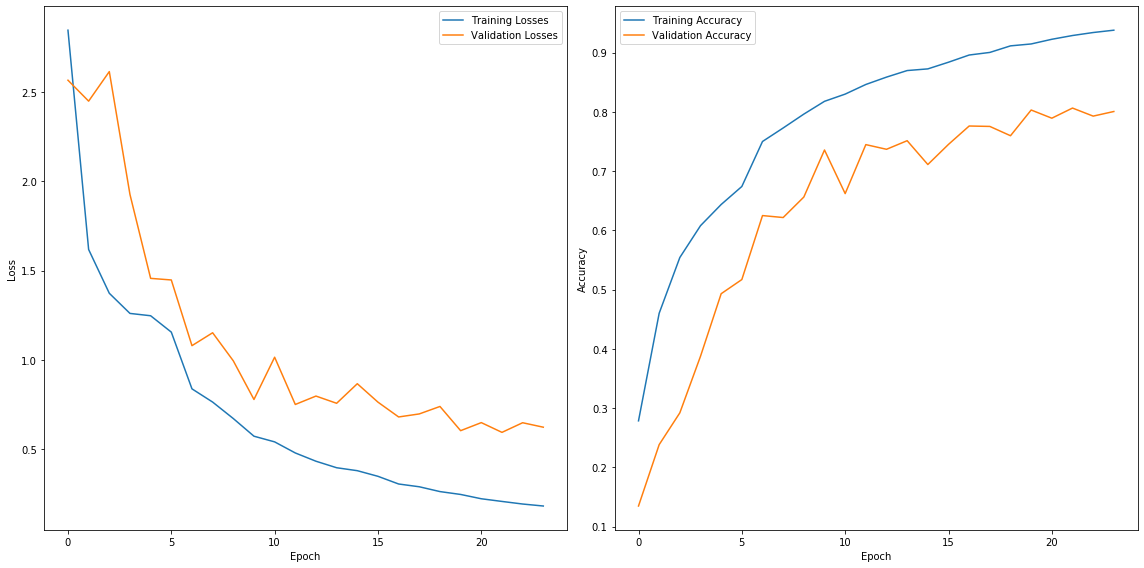

In [64]:
plot_diagnostics(ldict)

In [65]:
test_res=test(model,test_dl,loss_func,device='cuda')

In [66]:
test_res

{'Loss': 0.6229256416320801, 'Accuracy': 80.06}